# IEOR 174 Discussion 6

**Table of contents**<a id='toc0_'></a>    
1. [Acceptance-Rejection Method](#toc1_) 
2. [Thining method](#toc2_)   

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# <a id='toc1_'></a>[Acceptance-Rejection Method](#toc0_)

The **Acceptance-Rejection method** (or rejection sampling) is an algorithm for generating random samples from a probability distribution that is otherwise difficult to sample from directly. It works by using a simpler "proposal" distribution and probabilistically deciding whether to keep or discard the samples it generates.

---

## The Goal and the Setup

Imagine you want to generate random numbers that follow a complex **target probability density function (PDF)**, which we'll call **$f(x)$**. The problem is that you don't have a direct way to sample from it.

The solution is to find another, simpler PDF, called the **proposal distribution**, **$g(x)$**, which you *can* easily sample from (e.g., a uniform or normal distribution).

To make this work, we need one more ingredient: a constant **$c$** that satisfies the **envelope condition**:

$$c \cdot g(x) \ge f(x)$$

This must be true for all possible values of $x$. This means the scaled proposal function, $c \cdot g(x)$, acts as an "envelope" that completely covers our target function $f(x)$.



## The Geometric Intuition

The easiest way to understand the method is visually. Think of it as throwing darts at a 2D graph.

1.  **Sampling Under the Envelope:** First, we generate a random point that is uniformly distributed under the area of our scaled proposal curve, $c \cdot g(x)$. To do this, we sample a candidate x-value, $Z$, from our proposal distribution $g(\cdot)$. Then we generate a random y-value by sampling $U$ from Uniform(0,1) and calculating $Y = c \cdot g(Z)U$. The resulting point $(Z, Y)$ is a random "dart" thrown uniformly at the area under the envelope.

2.  **The Acceptance Test:** Next, we check if this dart landed *under* our target curve, $f(x)$. The condition for this is simply checking if the y-coordinate is less than the value of the target function at that x-coordinate:
    $$Y < f(Z) \quad \text{or} \quad c \cdot g(Z)U < f(Z)$$

3.  **Accept or Reject:** If the point falls under the target curve, we **accept** the x-value, $Z$, as a valid sample from our target distribution $f(x)$. If it falls outside (i.e., between $f(Z)$ and $c \cdot g(Z)$), we **reject** it and start over.

By only keeping the x-coordinates of the "darts" that land under the target curve, we ensure that the collection of accepted samples follows the distribution defined by $f(x)$.

### Demonstration
* **Target Distribution ($f(x)$):** We are using a **Beta distribution** with parameters $\alpha=2$ and $\beta=5$, denoted as `Beta(2, 5)`. This function is defined on the interval $[0, 1]$ and has a distinct, non-uniform shape, making it a good candidate for this experiment.

* **Proposal Distribution ($g(x)$):** We are using a **Uniform distribution** over the interval $[0, 1]$, denoted as `Uniform(0, 1)`. This is one of the simplest possible distributions to sample from, as its probability density is a constant value of 1 within its domain.

* **Scaling Constant ($c$):** A constant `c` is chosen to create an "envelope" function, $c \cdot g(x)$, that is always greater than or equal to the target function, $f(x)$. The maximum value of the `Beta(2, 5)` PDF is approximately 2.46. To ensure the envelope condition is met, a constant of **$c = 2.5$** was selected.


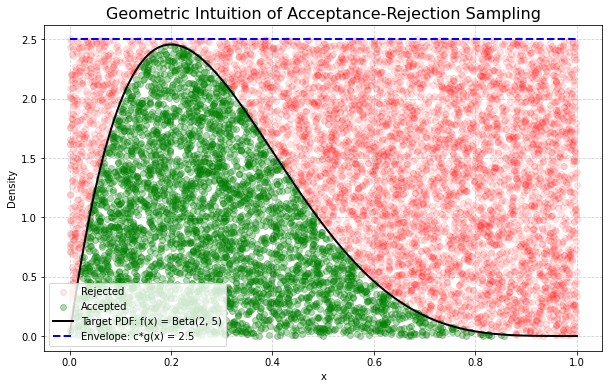

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# 1. Define the target and proposal distributions
# Target: Beta distribution PDF
alpha, b = 2, 5
f = lambda x: beta.pdf(x, alpha, b)

# Proposal: Uniform(0, 1) distribution PDF, g(x) = 1
g = lambda x: 1.0

# Constant c
c = 2.5

# Number of points to generate
num_points = 10000

# 2. Generate candidate points
z = np.random.uniform(0, 1, num_points)
y = np.random.uniform(0, c * g(z), num_points)

# 3. Perform the acceptance/rejection test
accepted_mask = y < f(z)

# Separate the points for plotting
accepted_points_x = z[accepted_mask]
accepted_points_y = y[accepted_mask]
rejected_points_x = z[~accepted_mask]
rejected_points_y = y[~accepted_mask]

# 4. Plot the results
plt.figure(figsize=(10, 6))

# Plot rejected and accepted points
plt.scatter(rejected_points_x, rejected_points_y, color='red', alpha=0.1, label='Rejected')
plt.scatter(accepted_points_x, accepted_points_y, color='green', alpha=0.3, label='Accepted')

# --- PLOTTING THE CURVES ---
x_curve = np.linspace(0, 1, 500)
y_f_curve = f(x_curve)


y_cg_curve = np.full(x_curve.shape, c * g(1.0)) # Corrected line

plt.plot(x_curve, y_f_curve, 'k-', linewidth=2, label='Target PDF: f(x) = Beta(2, 5)')
plt.plot(x_curve, y_cg_curve, 'b--', linewidth=2, label=f'Envelope: c*g(x) = {c}')

# Formatting
plt.title('Geometric Intuition of Acceptance-Rejection Sampling', fontsize=16)
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## The Algorithm

This intuition translates into a simple, step-by-step algorithm.

1.  **Choose a Proposal:** Select a proposal PDF $g(x)$ you can easily sample from and find a constant $c$ such that $c \cdot g(x) \geq f(x)$ for all $x$.
2.  **Generate a Candidate:** Draw a random sample $z$ from the proposal distribution $g(x)$.
3.  **Generate a Test Value:** Draw a random sample $u$ from a Uniform(0, 1) distribution.
4.  **Perform the Test:** Check if the following inequality holds:
    $$u < \frac{f(z)}{c \cdot g(z)}$$
    *(This is just a convenient rearrangement of the inequality from the geometric intuition).*
5.  **Decide:**
    * **Accept:** If the inequality is true, keep $z$ as your sample from the target distribution $f(x)$.
    * **Reject:** If the inequality is false, discard $z$ and go back to Step 2.


### Example 1: Truncated Normal Distribution

This experiment samples from a standard normal distribution truncated to the interval `[1, 2]`. Candidates are drawn from a full standard normal distribution and are only accepted if they fall within the target range and pass the probabilistic test.

* **Target PDF ($f(x)$):**
    $$f(x) = \frac{\phi(x)}{\Phi(2) - \Phi(1)} \quad \text{for } x \in [1, 2]$$
    where $\phi(x)$ is the standard normal PDF and $\Phi(x)$ is its CDF.

* **Proposal PDF ($g(x)$):**
    $$g(x) = \phi(x)$$

* **Envelope Condition:** With $c = \frac{1}{\Phi(2) - \Phi(1)}$, the envelope is:
    $$c \cdot g(x) = \frac{\phi(x)}{\Phi(2) - \Phi(1)}$$

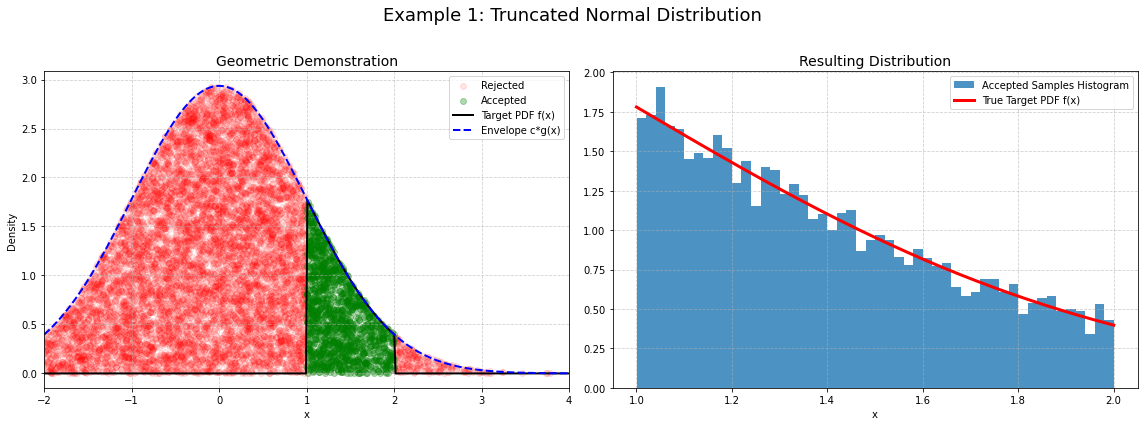

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Setting ---
# Target: A standard normal distribution truncated to the interval [1, 2]
Z = norm.cdf(2) - norm.cdf(1)

# ** HERE IS THE FIX **
# The lambda function is now vectorized using np.where to handle array inputs.
f = lambda x: np.where((x >= 1) & (x <= 2), norm.pdf(x) / Z, 0)

# Proposal: A standard normal distribution
g = lambda x: norm.pdf(x)

# Constant 'c'
c = 1 / Z

# --- Algorithm for collecting samples ---
num_samples = 5000
accepted_samples = []
while len(accepted_samples) < num_samples:
    z_candidate = np.random.normal(0, 1)
    # The original lambda definition would work here because we pass one value at a time.
    # The error occurred in the visualization part, which uses arrays.
    # For consistency, we use the robust vectorized version everywhere.
    u_test = np.random.uniform(0, 1)
    # Re-writing the acceptance test to use the vectorized f is cleaner
    if f(z_candidate) > 0: # Check if the candidate is in the valid range
        if u_test <= f(z_candidate) / (c * g(z_candidate)):
            accepted_samples.append(z_candidate)

# --- Data for Geometric Plot (Left Panel) ---
num_viz_points = 10000
z_viz = np.random.normal(0, 1, num_viz_points)
y_viz = np.random.uniform(0, c * g(z_viz), num_viz_points)
accepted_mask_viz = (y_viz < f(z_viz)) # The vectorized 'f' makes this simple and correct

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Example 1: Truncated Normal Distribution', fontsize=18)

# Left Panel: Geometric Demonstration
ax1.set_title('Geometric Demonstration', fontsize=14)
ax1.scatter(z_viz[~accepted_mask_viz], y_viz[~accepted_mask_viz], color='red', alpha=0.1, label='Rejected')
ax1.scatter(z_viz[accepted_mask_viz], y_viz[accepted_mask_viz], color='green', alpha=0.3, label='Accepted')
x_range_wide = np.linspace(-2, 4, 400)
ax1.plot(x_range_wide, f(x_range_wide), 'k-', linewidth=2, label='Target PDF f(x)')
ax1.plot(x_range_wide, c * g(x_range_wide), 'b--', linewidth=2, label='Envelope c*g(x)')
ax1.set_xlabel('x')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_xlim(-2, 4)

# Right Panel: Histogram vs. True Target
ax2.set_title('Resulting Distribution', fontsize=14)
ax2.hist(accepted_samples, bins=50, density=True, label='Accepted Samples Histogram', alpha=0.8)
x_range_narrow = np.linspace(1, 2, 200)
ax2.plot(x_range_narrow, f(x_range_narrow), 'r-', linewidth=3, label='True Target PDF f(x)')
ax2.set_xlabel('x')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Experiment 2: Custom Sine-Squared Shape

This experiment samples from an unnormalized density function to demonstrate that the method works even without a formal PDF. It uses a simple uniform distribution as the proposal to generate samples that follow the shape of a sine-squared curve.

* **Target Shape ($\tilde{f}(x)$):**
    $$\tilde{f}(x) = (\sin(\pi x))^2 \quad \text{for } x \in [0, 1]$$

* **Proposal PDF ($g(x)$):**
    $$g(x) = 1 \quad \text{for } x \in [0, 1]$$

* **Envelope Condition:** The algorithm requires $c \cdot g(x) \ge \tilde{f}(x)$. With $c=1.0$, the envelope is:
    $$1.0 \cdot 1 \ge (\sin(\pi x))^2$$

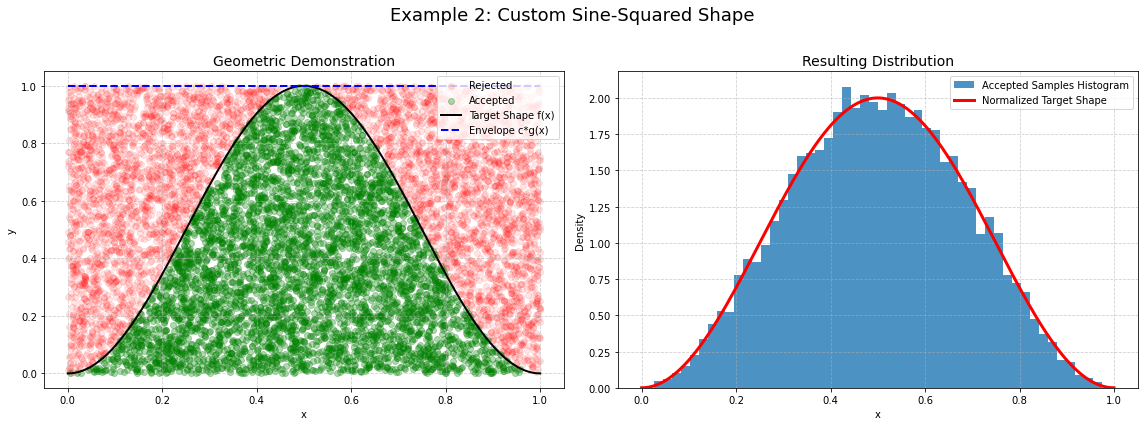

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --- Setting ---
# The target shape function, made robust with np.where
f_shape = lambda x: np.where((x >= 0) & (x <= 1), (np.sin(np.pi * x))**2, 0)

# ** HERE IS THE FIX **
# The proposal function is now vectorized to return an array of the correct shape.
g = lambda x: np.ones_like(x)

# Constant 'c'
c = 1.0

# --- Algorithm for collecting samples ---
num_samples = 10000
accepted_samples = []
while len(accepted_samples) < num_samples:
    z_candidate = np.random.uniform(0, 1)
    # Note: g(z_candidate) now returns an array of size 1, but c * [1.0] is still valid
    u_test = np.random.uniform(0, 1)
    if u_test <= f_shape(z_candidate) / (c * g(z_candidate)):
        accepted_samples.append(z_candidate)

# --- Data for Geometric Plot (Left Panel) ---
num_viz_points = 10000
z_viz = np.random.uniform(0, 1, num_viz_points)
y_viz = np.random.uniform(0, c * g(z_viz), num_viz_points)
accepted_mask_viz = y_viz < f_shape(z_viz)

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Example 2: Custom Sine-Squared Shape', fontsize=18)

# Left Panel: Geometric Demonstration
ax1.set_title('Geometric Demonstration', fontsize=14)
ax1.scatter(z_viz[~accepted_mask_viz], y_viz[~accepted_mask_viz], color='red', alpha=0.1, label='Rejected')
ax1.scatter(z_viz[accepted_mask_viz], y_viz[accepted_mask_viz], color='green', alpha=0.3, label='Accepted')
x_range = np.linspace(0, 1, 400)
ax1.plot(x_range, f_shape(x_range), 'k-', linewidth=2, label='Target Shape f(x)')
ax1.plot(x_range, c * g(x_range), 'b--', linewidth=2, label='Envelope c*g(x)') # This line now works
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# Right Panel: Histogram vs. True Target
ax2.set_title('Resulting Distribution', fontsize=14)
ax2.hist(accepted_samples, bins=50, density=True, label='Accepted Samples Histogram', alpha=0.8)
# Normalize the true shape for comparison (area under shape is 0.5)
ax2.plot(x_range, f_shape(x_range) / 0.5, 'r-', linewidth=3, label='Normalized Target Shape')
ax2.set_xlabel('x')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Experiment 3: Gamma from an Exponential Distribution

This experiment samples from a `Gamma(2, 1)` distribution using a wider `Exponential(2)` distribution as the proposal. This demonstrates a more complex case where the proposal and target have different functional forms.

* **Target PDF ($f(x)$):** `Gamma(shape=2, scale=1)`
    $$f(x) = x e^{-x} \quad \text{for } x > 0$$

* **Proposal PDF ($g(x)$):** `Exponential(scale=2)`
    $$g(x) = \frac{1}{2} e^{-x/2} \quad \text{for } x > 0$$

* **Envelope Condition:** The constant is set to $c=1.5$ to ensure $c \cdot g(x) \ge f(x)$. The envelope is:
    $$c \cdot g(x) = 1.5 \cdot \frac{1}{2} e^{-x/2} = 0.75 e^{-x/2}$$

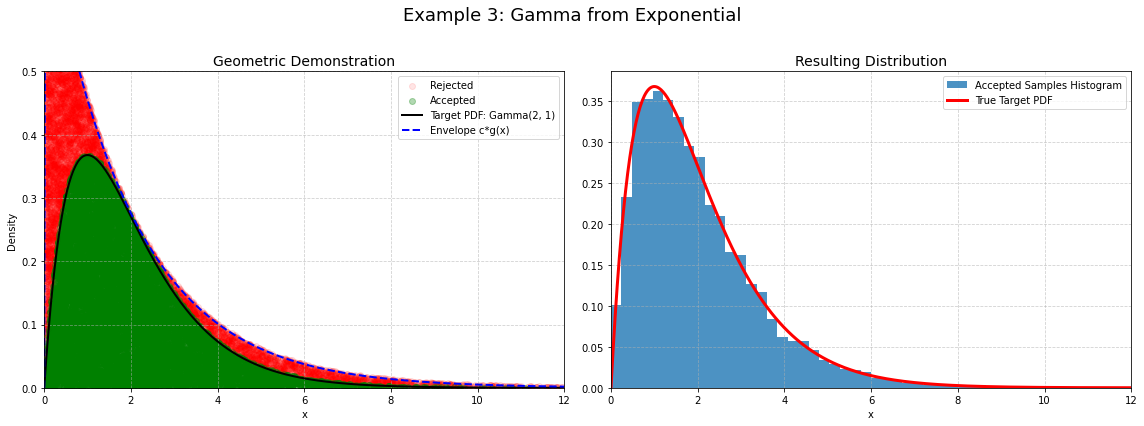

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, expon

# --- Setting ---
# The scipy.stats functions are already vectorized, but we make the domain explicit
# for clarity and consistency. This change is for robustness, not fixing an error.
f = lambda x: np.where(x > 0, gamma.pdf(x, a=2, scale=1), 0)
g = lambda x: np.where(x > 0, expon.pdf(x, scale=2), 0)

sample_g = lambda: np.random.exponential(scale=2)

# Constant 'c':
c = 1.5

# --- Algorithm for collecting samples ---
num_samples = 10000
accepted_samples = []
while len(accepted_samples) < num_samples:
    z_candidate = sample_g()
    u_test = np.random.uniform(0, 1)
    if u_test <= f(z_candidate) / (c * g(z_candidate)):
        accepted_samples.append(z_candidate)

# --- Data for Geometric Plot (Left Panel) ---
num_viz_points = 20000
z_viz = np.random.exponential(scale=2, size=num_viz_points)
y_viz = np.random.uniform(0, c * g(z_viz), num_viz_points)
accepted_mask_viz = y_viz < f(z_viz)

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Example 3: Gamma from Exponential', fontsize=18)

# Left Panel: Geometric Demonstration
ax1.set_title('Geometric Demonstration', fontsize=14)
ax1.scatter(z_viz[~accepted_mask_viz], y_viz[~accepted_mask_viz], color='red', alpha=0.1, label='Rejected')
ax1.scatter(z_viz[accepted_mask_viz], y_viz[accepted_mask_viz], color='green', alpha=0.3, label='Accepted')
x_range = np.linspace(0, 12, 500)
ax1.plot(x_range, f(x_range), 'k-', linewidth=2, label='Target PDF: Gamma(2, 1)')
ax1.plot(x_range, c * g(x_range), 'b--', linewidth=2, label='Envelope c*g(x)')
ax1.set_xlabel('x')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_xlim(0, 12)
ax1.set_ylim(0, 0.5)


# Right Panel: Histogram vs. True Target
ax2.set_title('Resulting Distribution', fontsize=14)
ax2.hist(accepted_samples, bins=50, density=True, label='Accepted Samples Histogram', alpha=0.8, range=(0,12))
ax2.plot(x_range, f(x_range), 'r-', linewidth=3, label='True Target PDF')
ax2.set_xlabel('x')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_xlim(0, 12)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Efficiency

The efficiency of the Acceptance-Rejection method is the probability that a candidate sample drawn from the proposal distribution is accepted. This probability is equal to $1/c$. Consequently, the average number of candidates you must generate to get one accepted sample is $c$. To make the algorithm efficient, the constant $c$ should be chosen to be as close to 1 as possible.

---

### Proof

Let $A$ be the event that a candidate sample, $Z \sim g(z)$, is accepted. We want to find the overall probability of this event, $P(A)$. Using the law of total probability, we can integrate the conditional probability of acceptance over all possible values of $Z$:

$$P(A) = \int_{-\infty}^{\infty} P(A | Z=z) \cdot g(z) \,dz$$

The conditional probability of acceptance for a specific candidate $z$, $P(A | Z=z)$, is the probability that a uniform random variable $U$ satisfies the acceptance condition:

$$P(A | Z=z) = P\left(U \le \frac{f(z)}{c \cdot g(z)}\right)$$

Since $U \sim \text{Uniform}(0, 1)$, this probability is simply the value on the right-hand side:

$$P(A | Z=z) = \frac{f(z)}{c \cdot g(z)}$$

Substituting this back into the integral:

$$P(A) = \int_{-\infty}^{\infty} \left(\frac{f(z)}{c \cdot g(z)}\right) \cdot g(z) \,dz$$

The $g(z)$ terms cancel out:

$$P(A) = \int_{-\infty}^{\infty} \frac{f(z)}{c} \,dz$$

Since $c$ is a constant, we can pull it out of the integral. The integral of any probability density function $f(z)$ over its entire domain is equal to 1.

$$P(A) = \frac{1}{c} \int_{-\infty}^{\infty} f(z) \,dz = \frac{1}{c} \cdot 1$$

Therefore, the overall probability of acceptance is:

$$P(A) = \frac{1}{c}$$

Running simulations for different values of c...
Simulations complete. Generating plot...


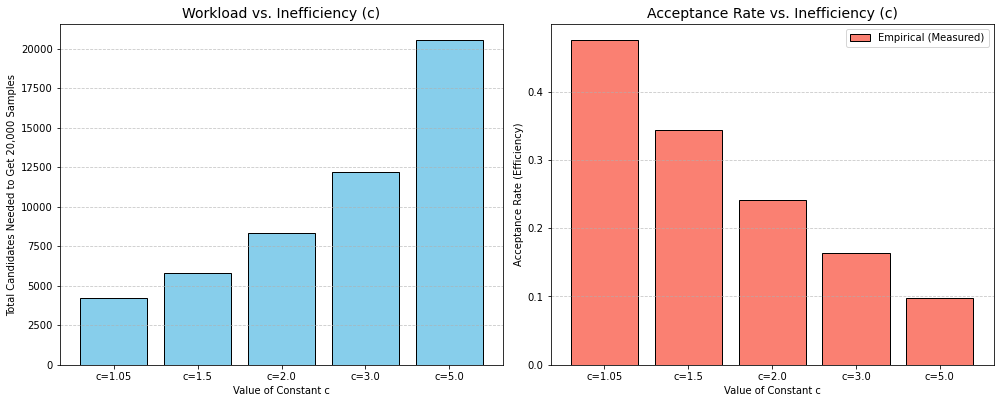

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# --- Setting ---
# Target Shape: A function that looks like a hump.
f_shape = lambda x: np.where((x >= 0) & (x <= 1), (np.sin(np.pi * x))**2, 0)

# Proposal: A Uniform(0, 1) distribution, g(x) = 1
g = lambda x: np.ones_like(x)

# --- Experiment ---
# We will test several different values for the constant 'c'.
c_values = [1.05, 1.5, 2.0, 3.0, 5.0] 
num_accepted_needed = 2000

# Lists to store results for plotting
total_candidates_list = []
empirical_efficiencies = []
theoretical_efficiencies = []

print("Running simulations for different values of c...")

for c in c_values:
    accepted_count = 0
    total_candidates = 0
    
    while accepted_count < num_accepted_needed:
        total_candidates += 1
        z_candidate = np.random.uniform(0, 1)
        u_test = np.random.uniform(0, 1)
        
        if u_test <= f_shape(z_candidate) / (c * g(z_candidate)):
            accepted_count += 1
            
    # Store results
    total_candidates_list.append(total_candidates)
    empirical_efficiencies.append(accepted_count / total_candidates)
    theoretical_efficiencies.append(1 / c)

print("Simulations complete. Generating plot...")

# --- Visualization ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
#fig.suptitle('Visualizing the Efficiency of Acceptance-Rejection Sampling', fontsize=18)
c_labels = [f"c={c}" for c in c_values]

# Left Panel: Total candidates required
ax1.bar(c_labels, total_candidates_list, color='skyblue', edgecolor='black')
ax1.set_title('Workload vs. Inefficiency (c)', fontsize=14)
ax1.set_ylabel('Total Candidates Needed to Get 20,000 Samples')
ax1.set_xlabel('Value of Constant c')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Right Panel: Acceptance Rate (Efficiency)
ax2.bar(c_labels, empirical_efficiencies, color='salmon', edgecolor='black', label='Empirical (Measured)')
#ax2.plot(c_labels, theoretical_efficiencies, 'ko-', label='Theoretical (1/c)', markersize=8)
ax2.set_title('Acceptance Rate vs. Inefficiency (c)', fontsize=14)
ax2.set_ylabel('Acceptance Rate (Efficiency)')
ax2.set_xlabel('Value of Constant c')
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# <a id='toc2_'></a>[2. Thinning method](#toc0_) 

The thinning method is an algorithm for simulating a **non-homogeneous Poisson process (NHPP)**, where the event rate, or **intensity function $\lambda(t)$**, changes over time.

The core idea is to **overproduce** candidate events using a simple, high-constant-rate process, and then **filter** (or "thin") them to match the desired variable rate. 

***

## The Algorithm

To simulate events in a time interval $[0, T]$:

1.  **Find the Ceiling Rate:** Determine the maximum rate over the interval: $\lambda^* = \max_{0 \le t \le T} \lambda(t)$.

2.  **Generate Candidates:** Simulate a *homogeneous* Poisson process with the constant rate $\lambda^*$ to generate a set of candidate event times $\{t_1, t_2, \dots, t_n\}$.

3.  **Thin the Candidates:** For each candidate time $t_i$:
    * Generate a random number $U$ from a Uniform(0, 1) distribution.
    * **Accept** the event time $t_i$ if $U \le \frac{\lambda(t_i)}{\lambda^*}$.
    * Otherwise, **reject** the event.

The final collection of **accepted** times is the simulated NHPP. The probability of keeping an event at any time $t_i$ is proportional to the true rate $\lambda(t_i)$, correctly shaping the final output.


### The validity of the thinning method

We start with a **candidate** homogeneous Poisson process (HPP) with a constant rate $\lambda^*$. The probability of a candidate event occurring in a tiny time interval $dt$ is:
$$P(\text{candidate}) \approx \lambda^* \cdot dt$$
Each candidate event at time $t$ is then independently **accepted** with a probability of:
$$P(\text{acceptance}) = \frac{\lambda(t)}{\lambda^*}$$
The probability of a final, **accepted event** occurring in the interval $dt$ is the product of these two independent probabilities:
$$P(\text{accepted event}) \approx (\lambda^* \cdot dt) \times \left( \frac{\lambda(t)}{\lambda^*} \right) = \lambda(t) \cdot dt$$

This result is the definition of a non-homogeneous Poisson process with the desired intensity function $\lambda(t)$. 

## Example

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define the time-varying intensity function lambda(t)
def intensity_function(t):
    """A simple sine wave intensity function for demonstration."""
    return 5 + 4 * np.sin(t)

def simulate_nhpp_thinning(lambda_func, T, lambda_max):
    """
    Simulates a non-homogeneous Poisson process (NHPP) using the thinning method.

    Args:
        lambda_func (function): The time-varying intensity function lambda(t).
        T (float): The total time duration of the process.
        lambda_max (float): The maximum value of lambda_func over [0, T].

    Returns:
        np.array: An array of event times for the simulated NHPP.
    """
    # --- Step 1: Generate Candidate Events from a Homogeneous PP ---
    # The number of candidate events is Poisson distributed with mean lambda_max * T
    num_candidates = np.random.poisson(lambda_max * T)
    
    # Generate the candidate event times uniformly over [0, T]
    candidate_times = np.random.uniform(0, T, num_candidates)
    candidate_times.sort() # Sort times to be chronological

    # --- Step 2: Thin the Candidate Events ---
    accepted_times = []
    rejected_times = [] # Keep track for visualization
    
    for t in candidate_times:
        # Calculate the acceptance probability
        acceptance_prob = lambda_func(t) / lambda_max
        
        # Accept the event with this probability
        if np.random.uniform(0, 1) < acceptance_prob:
            accepted_times.append(t)
        else:
            rejected_times.append(t)
            
    return np.array(accepted_times), np.array(rejected_times), candidate_times

# --- Simulation Parameters ---
T_total = 20  # Total time
lambda_star = 9.0  # Maximum rate (5 + 4*1 = 9)

# Run the simulation
accepted_events, rejected_events, all_candidates = simulate_nhpp_thinning(intensity_function, T_total, lambda_star)

print(f"Total candidate events: {len(all_candidates)}")
print(f"Accepted events (final count): {len(accepted_events)}")
print(f"Rejected events: {len(rejected_events)}")

Total candidate events: 190
Accepted events (final count): 107
Rejected events: 83


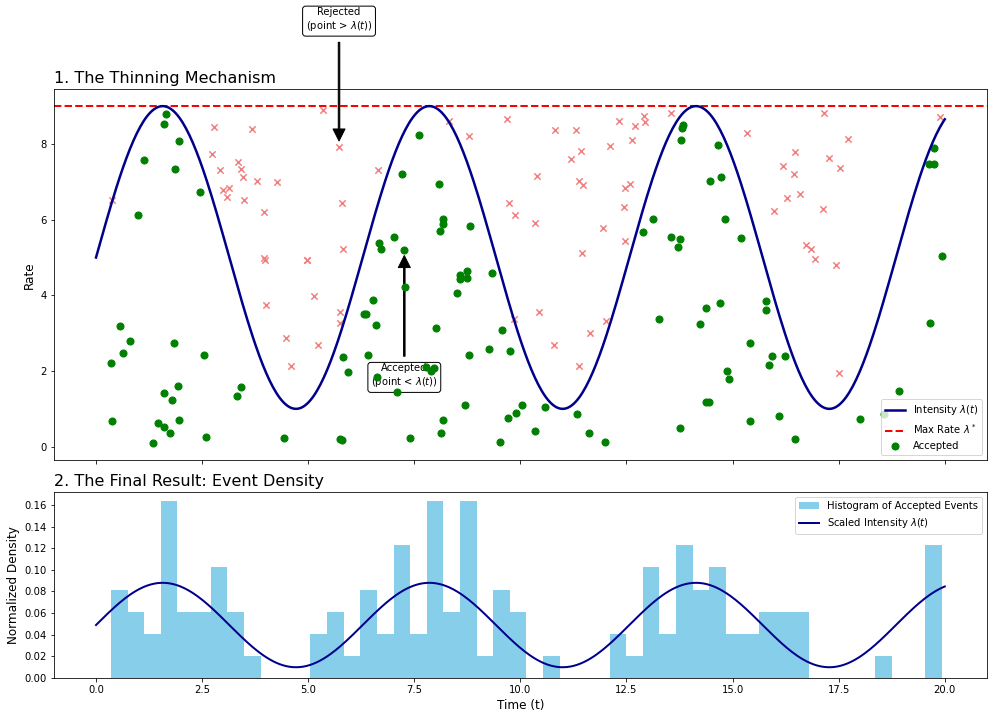

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# --- Use the same simulation function from before ---
def intensity_function(t):
    return 5 + 4 * np.sin(t)

def simulate_nhpp_thinning(lambda_func, T, lambda_max):
    num_candidates = np.random.poisson(lambda_max * T)
    candidate_times = np.random.uniform(0, T, num_candidates)
    
    accepted_times = []
    for t in candidate_times:
        if np.random.uniform(0, 1) < lambda_func(t) / lambda_max:
            accepted_times.append(t)
            
    return np.array(accepted_times), np.array(candidate_times)

# --- Simulation Parameters ---
T_total = 20
lambda_star = 9.0
accepted_events, candidate_events = simulate_nhpp_thinning(intensity_function, T_total, lambda_star)

# --- Create the Improved Visualization ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})


# --- TOP PLOT: The Thinning Mechanism ---
t_plot = np.linspace(0, T_total, 500)
lambda_plot = intensity_function(t_plot)

# Plot the intensity function and the max rate
ax1.plot(t_plot, lambda_plot, label='Intensity $\lambda(t)$', color='darkblue', lw=2.5, zorder=10)
ax1.axhline(y=lambda_star, label='Max Rate $\lambda^*$', color='red', linestyle='--', lw=2)

# Plot candidate points. We need to distinguish accepted vs rejected for coloring.
y_values_candidates = np.random.uniform(0, lambda_star, len(candidate_events))

for i, t in enumerate(candidate_events):
    # Check if the candidate's y-value falls under the curve
    if y_values_candidates[i] < intensity_function(t):
        ax1.scatter(t, y_values_candidates[i], c='green', s=50, zorder=5, label='Accepted' if t == candidate_events[0] else "") # Label once
    else:
        ax1.scatter(t, y_values_candidates[i], c='lightcoral', marker='x', s=40, zorder=4, label='Rejected' if t == candidate_events[1] else "")

# Add Annotations for clarity
# Find a sample accepted and rejected point to annotate
try:
    idx_acc = np.where(y_values_candidates < intensity_function(candidate_events))[0][0]
    idx_rej = np.where(y_values_candidates >= intensity_function(candidate_events))[0][0]
    
    ax1.annotate('Accepted\n(point < $\lambda(t)$)', 
                 xy=(candidate_events[idx_acc], y_values_candidates[idx_acc]), 
                 xytext=(candidate_events[idx_acc], y_values_candidates[idx_acc] - 3),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                 ha='center', va='top', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))

    ax1.annotate('Rejected\n(point > $\lambda(t)$)', 
                 xy=(candidate_events[idx_rej], y_values_candidates[idx_rej]), 
                 xytext=(candidate_events[idx_rej], y_values_candidates[idx_rej] + 3),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                 ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))
except IndexError:
    print("Could not find suitable points for annotation.")


ax1.set_title('1. The Thinning Mechanism', fontsize=16, loc='left')
ax1.set_ylabel('Rate', fontsize=12)
ax1.legend()


# --- BOTTOM PLOT: The Final Result ---
# Plot a histogram of the accepted events
ax2.hist(accepted_events, bins=50, density=True, color='skyblue', label='Histogram of Accepted Events')

# Overlay the scaled intensity function to compare shapes
# The integral of the PDF (histogram) is 1. The integral of lambda(t) is the total # of events.
# We scale lambda(t) to have the same area as the histogram for visual comparison.
total_events_mean = np.trapz(lambda_plot, t_plot)
ax2.plot(t_plot, lambda_plot / total_events_mean, color='darkblue', lw=2, label='Scaled Intensity $\lambda(t)$')

ax2.set_title('2. The Final Result: Event Density', fontsize=16, loc='left')
ax2.set_xlabel('Time (t)', fontsize=12)
ax2.set_ylabel('Normalized Density', fontsize=12)
ax2.legend()

plt.tight_layout()
plt.show()